<a href="https://colab.research.google.com/github/retico/cmepda_medphys/blob/master/L7_code/DL_classification_MedPhys_STUDENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of lesions in Medical Physics 

The aim of this exercise is to create and train a simple Convolutional Neural Network (CNN) for deep-learning based classification of normal tissue vs. tissue cointaining microcalcification clusters in mammograms. 

Microcalcifications are tiny bright spots with diameter of few hundred microns, that are common findings in mammography. They appearance may be masked by the highly heterogenous breast tissue. While isolated microcalcifications are generally benign, when they occur grouped in clusters with suspicious morphology and distribution patterns, they are associated with the risk of malignancy.   





Mammography (see the figure below) is a diagnostic imaging modality based on X-rays, with extremely high resolution. Typical pixel size nowadays is 50 microns or less.

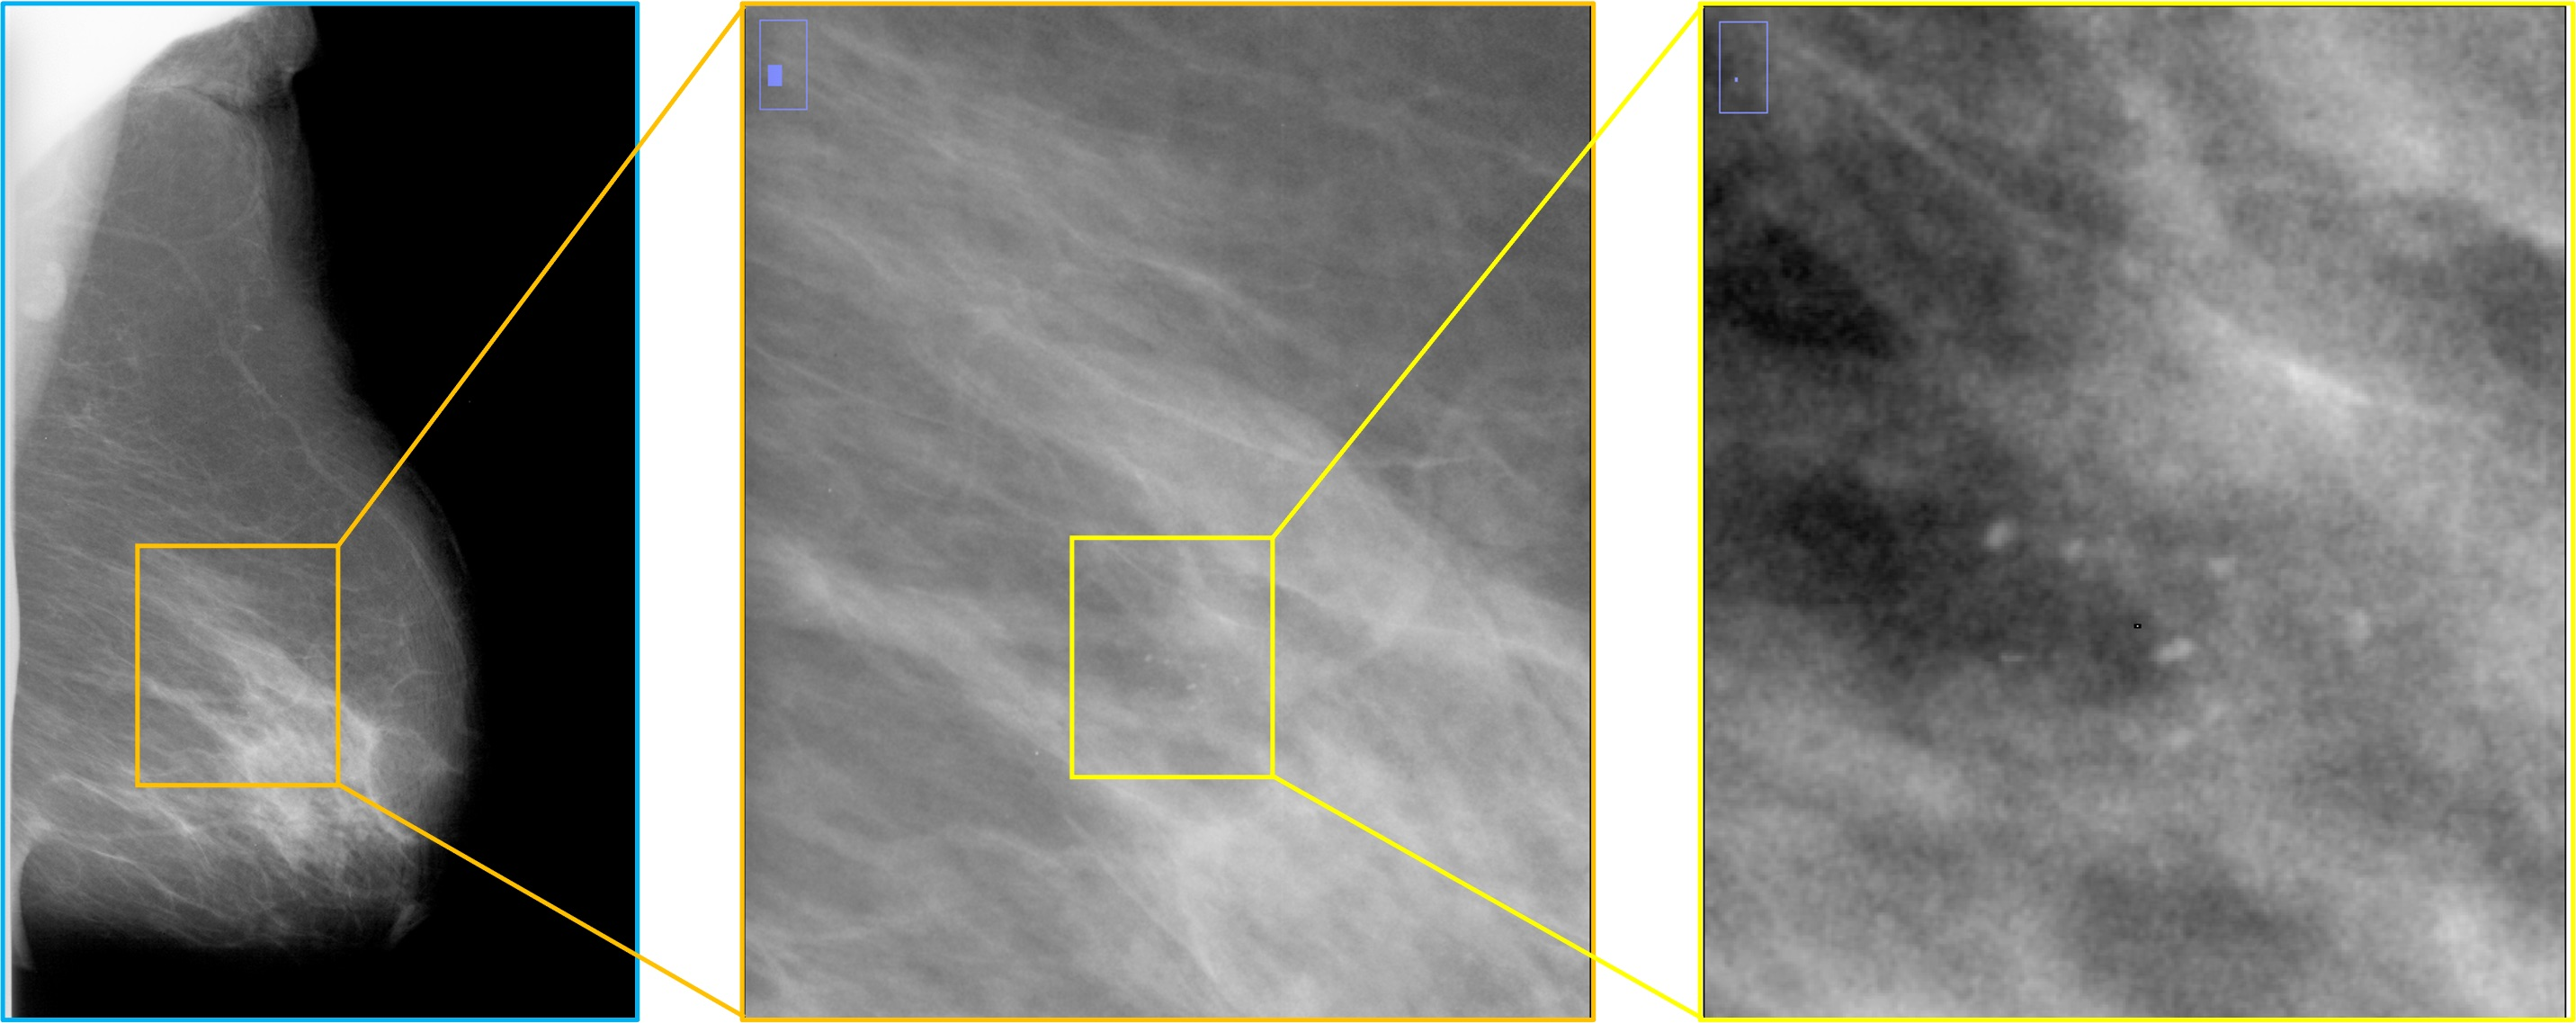

We will build a CNN classifier capable to distinguish images containing small potions of normal tissue, form images containing micorcacification clusters. The image portions we will examine are slightly smaller than the rightmost picture in the figure above.

If we set this classifier to scan sistematically  the whole mammogram, we would obtain an automated system for the detection and localization of microcalcification clusters. 

## Exercise objectives

In this exercise you will learn how to: 


*   Load and visualize image data
*   Define the CNN model
*   Compile and train the CNN model on the training data
*   Predict the labels of the validation/test data samples
*   Calculate the classification accuracy 
*   Create the ROC curve and calculate the AUC
*   Compare the performance of different models 


Additionally, if you have extra time now or when you get home, you will learn how to perform data augmentation. 

## Remark
The architecture of the CNN you will develop in this exercise can be trained on different kind of 2D images (with 1 color channel) even outside the medical imaging domain. 





## Description of the dataset

The dataset we will use contains many image portions (60x60 pixels, corresponding to 5.1 mm x 5.1 mm) extracted from real mammograms, with radiological annotations, and converted into 8-bit grayscale images. These images may contain microcalcification clusters (label = 1) or normal breast tissue (label = 0).

The available images are already partitioned in a train set and a test set, containing, respectively:
- Train set (70% of the whole sample): 289 images with normal tissue and 267 images with microcalcification clusters;  
- Test set (30% of the whole sample): 125 images with normal tissue and 116 images with microcalcification clusters. 

The test set should always be left apart from the training procedure and used as an independent set to evaluate the classifier performance.



Examples of images containing microcalcalfication clusters: 

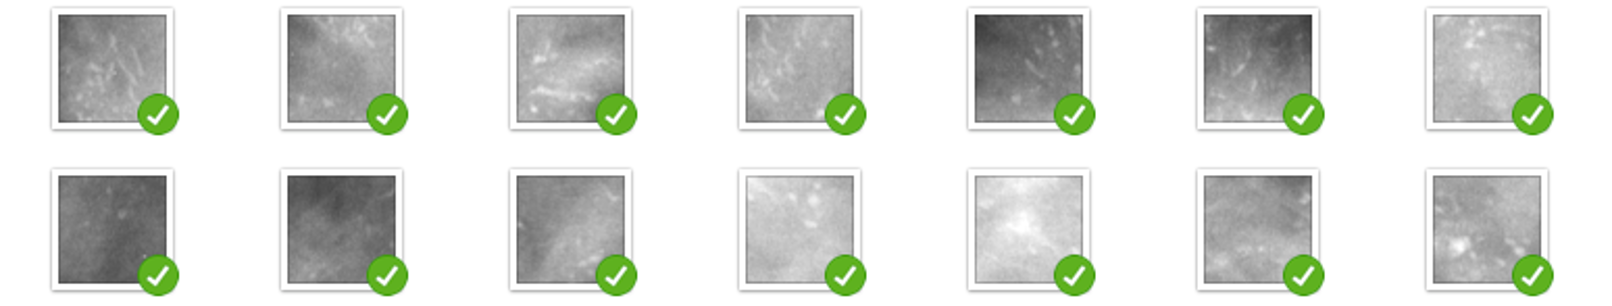

Examples of images representing normal breast tissue:

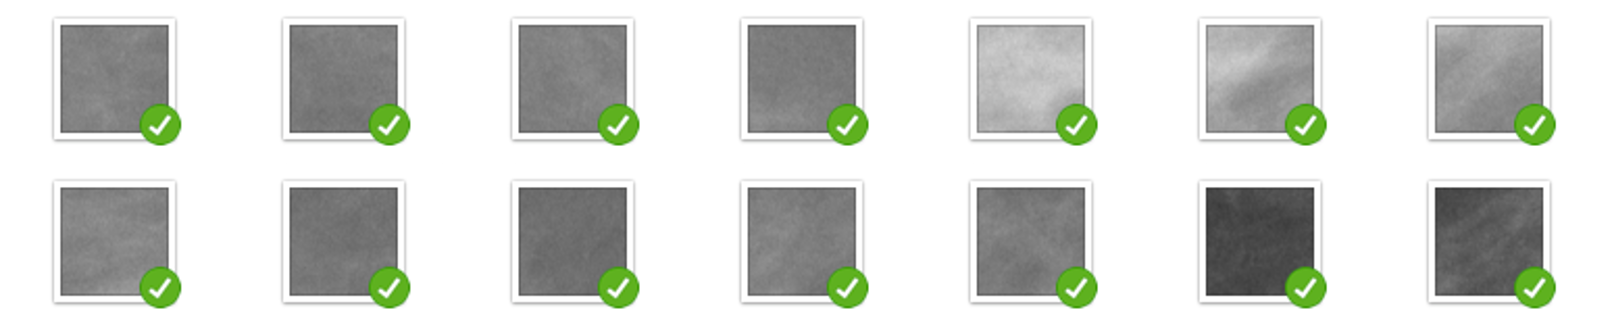

#Importing the dataset


We download the zipped data archive from a webserver.


In [ ]:
import os
if os.path.isfile('DL_class_data.tar.gz'):
    print ("File already exists... skipping download")
else:
    print ("Downloading File")
    !wget https://www.pi.infn.it/~boccali/DL_class_data.tar.gz

File already exists... skipping download


Now let's extract the archive.

NB: Using the special ```!``` charcter we can execute shell commands. 

In [ ]:
!tar -xvf DL_class_data.tar.gz

We can show all files and folders in a certain path using ```ls```.





In [ ]:
!ls 

In [ ]:
!ls Train/

Each folder should have mammogram images containing microcalcifications (label=1) or normal breast tissue (label=0) put in different subfolders.

In [ ]:
!ls {Test,Train} 

Remember that microcalcification clusters have label=1 and  normal breast tissue label=0. \\
The number of images for each folder should be as it follows:
```
Train 0 files: 289
Train 1 files: 267
Test 0 files: 125
Test 1 files: 116
```



You can check it with the following commands:

In [ ]:
!echo -n "Train 0 files: "; ls Train/0 | wc -l;
!echo -n "Train 1 files: "; ls Train/1 | wc -l;
!echo -n "Test 0 files: "; ls Test/0 | wc -l;
!echo -n "Test 1 files: "; ls Test/1 | wc -l;

You can print, for example, the filenames of the last three file  inside a folder, with the following instruction:

In [ ]:
!ls Train/1/ | tail -n 3

# Reading the images

We need to import some python packages (matplotlib, os, glob, numpy) and to install and import scikit-image to read and visualize images.



In [ ]:
!pip install scikit-image

In [ ]:
from skimage.io import imread
import matplotlib.pyplot as plt
import os
import glob
import numpy as np

Let us try to read an image with ```imread``` [[doc](https://scikit-image.org/docs/dev/api/skimage.io.html#skimage.io.imread)]. The output is a 2D array (since the image is in grayscale).
We can view the image through the package ```imshow``` of matplotlib [[doc](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html)].

In [ ]:
!ls Train/1 | tail -n 3

In [ ]:
#FILL HERE# Select an image from the list above and read it with imread 
sample_img = ...


#FILL HERE# Print the shape of the numpy array 
print("Shape of array:",...)

#FILL HERE# Show the sample_img using plt.imshow. You can select an appropriate color map (cmap) fro radiological images. 
...


We can define a function to read images from a certain ```dataset_path``` and ```classes``` that matches the subfolders containing labeled images.

The function uses the ```glob``` functions that finds all the pathnames that match a given pattern [[doc](https://docs.python.org/3/library/glob.html)].
The images are read though the package ```imread``` [[doc](https://scikit-image.org/docs/dev/api/skimage.io.html#skimage.io.imread)]. This list of read images is populated with list comprehensions [[doc](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions)].

The last line converts the ```tmp``` list into a numpy array storing float32 data, adding an extra dimension with ```np.newaxis``` [[doc](https://numpy.org/doc/stable/reference/constants.html#numpy.newaxis)] (the three dots ```...``` are a special indexing symbol called ellipsis [[doc](https://docs.python.org/dev/library/constants.html#Ellipsis)])

In [ ]:
def read_imgs(dataset_path, classes):
  tmp = []
  labels = []
  for cls in classes:
    # Returns all the images filenames contained in a certain folder
    fnames = glob.glob(os.path.join(dataset_path, str(cls), '*.png'))
    # Read, with a list comprehension, all the images listed before
    tmp += [ imread(fname) for fname in fnames ]
    # Populate the labels list with the label of the read image
    labels += len(fnames)*[cls]
 
  return np.array(tmp, dtype='float32')[..., np.newaxis]/255, np.array(labels)

We can use the ```read_imgs```
function to read all images in the dataset and store them in a numpy array, and to generate the appropriate numpy arrays with the labels corresponding to each instance.  


In [ ]:
train_dataset_path = 'Train'
x_train, y_train = read_imgs(train_dataset_path, [0, 1])

test_dataset_path = 'Test'
x_test, y_test = read_imgs(test_dataset_path, [0, 1])

It is always a good idea to print the shape of the array in use to check it. \
*x_train* is the array of the images, in our case the first dimension is the number of read images, the second and the third are the dimensions of each image, and the last one represents the color channel: (sample_dimension, image_width, image_height, color_channel). 
While *y_train* is the array containing the label of each image (0 or 1).



In [ ]:
#FILL HERE# Print the shape of the train and test arrays and their labels
print(...)

Plot the first image in the dataset using the *imshow* function of *matplotlib.pyplot*

In [ ]:
#We select the first image of the array (you can choose a different one)
img_1 = x_train[0].reshape(60,60)

#FILL HERE#-> Display the image using imshow. 
#You can also choose an appropriate colormap (cmap) 
...


# Defining a CNN model

Convolutional neural networks (CNN) are a class of neural networks usually used to classify images.
[[Ref1](https://www.asimovinstitute.org/neural-network-zoo/) ,
[Ref2](https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5)]

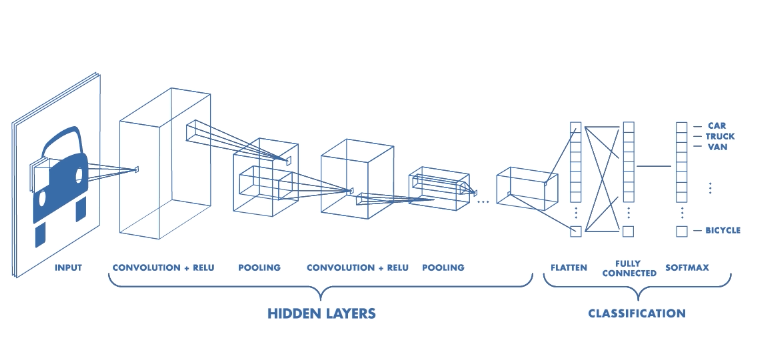

[Ref3](https://www.freecodecamp.org/news/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050/)

- In CNN, the nodes of the convolutional layers  are not connected to all nodes of previous layer. This is due to the high dimesionality of image data. For this reason we connect each node only to a local region of the input. 

- The nodes are called neurons or filter or kernel. The nodes/filters are convolved to the network layers and they slide through the whole image in order to cover all pixels.


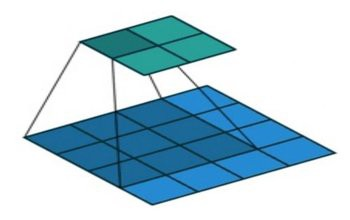

- Pooling layers. Pooling is a way to downsample the image: a common pooling technique is the "max pooling". A max pooling layer takes, for example, a 2x2 submatrix and returns the pixel with the maximum value
[[doc](https://keras.io/api/layers/pooling_layers/max_pooling2d/)].




The Keras library in Python makes it pretty simple to build a CNN.

- Models on Keras can be defined in two ways: sequential and functional. In the Sequential model, you define the model using a plain stack of layers and each layer has exactly one input and one output. In the functional one, each layer is defined as a function which can take as input the output of the previous layer. It allows also to merge, add and concatenate more than input. 


- Convolution layer
> - The first layer takes in an input shape. This is the shape of each input image.
> - Number of nodes in each layer `(8,16,32) `
> - Kernel size is the size of the filter matrix for our convolution. So a kernel size of 3 means we will have a 3x3 filter matrix.
> - What is the effect of using "padding = same"? 
> - Activation is the activation function for the layer. (ReLU or Rectified Linear Activation has been proven to work well in neural networks)

- 'Batch normalization' adds a ‘normalization layer’ after each convolutional layer. This allows the model to converge much faster in training and to generalize better. 

- ‘Dense’ is the layer we will use just before the output layer. It is a fully connected layer typical of a Multi Layer Perceptrons model.

- The last layer contains 1 node and a different activation function called "sigmoid". The sigmoid returns a probability distribution in the range of 0 to 1 (it is not the only possible activation!!!). The "sigmoid" is a good choice for the last layer for several reasons: 1) it is differentiable and monotonic, 2) it is a "smooth" function, 3) it simply exists between 0 and 1. However, it has also three main drowbacks: it returns predictions that are not zero-centered and it is computationally expensive; the third disadvantage, which is the reason why it is used only in the last layer, is that it may cause the "vanishing gradient". Why it may cause the vanishing gradient? Why is there just 1 node in the last layer? Is it possible to use another number of nodes for this specific problem?

\\


To prevent over-fitting we will use dropout layers. 
Overfitting happens when your model fits too well to the training set. It then becomes difficult for the model to generalize. 
Dropout works by stochastically removing, or “dropping out,” some nodes.




You can built your the CNN model using either the [sequential](https://keras.io/guides/sequential_model/) or the [functional](https://keras.io/guides/functional_api/) Keras API 
([Keras Sequential and Functional Models example](https://machinelearningmastery.com/keras-functional-api-deep-learning/))



In [ ]:
#FILL HERE# Import the keras.models according to the API you prefer
from keras.models import ... 

 
#FILL HERE# Import all layers which are needed to build your CNN
from keras.layers import ...


Create a CNN with approximately the following structure:

In [ ]:
#_________________________________________________________________
#Layer (type)                 Output Shape             
#=================================================================
#conv2d (Conv2D)              (None, 60, 60, num_filters)                
#_________________________________________________________________
#batch_normalization (BatchNo (None, 60, 60, num_filters)                
#_________________________________________________________________
#activation (Activation)      (None, 60, 60, num_filters)                 
#_________________________________________________________________
#max_pooling2d (MaxPooling2D) (None, xxx, xxx, num_filters)                 

# …. ADD 3-4 BLOCKS AT MOST CONTAINING conv2d, batch_normalization, activation, max_pooling2d LAYERS

#flatten (Flatten)            (None, xxx)                      
#_________________________________________________________________
#dense (Dense)                (None, num_nodes)                    
#_________________________________________________________________
#dropout (Dropout)            (None, xxx)                        
#_________________________________________________________________
#dense_1 (Dense)              (None, num_nodes)                        
#=================================================================

You have to arbitrarily choose a number of free parameters to build your model. Check the Keras documentation for each type of [layer](https://keras.io/api/layers/).  

In [ ]:
#FILL HERE# Build you CNN 

def make_model(shape=(...)):
  .....
  .....
  .....
  
  return model

model = make_model()
model.summary()

You can plot your model also with the [*plot_model*](https://keras.io/api/utils/model_plotting_utils/) function 

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

Next, we need to compile our model. Compiling the model takes three parameters: optimizer, loss and metrics.
- The loss function ‘binary_crossentropy’ is the most common choice for classification and represents the function we want to minimize.
- The optimizer is the algorithm procedure for minimizing the loss. A pivotal parameter of the optimizer is the learning rate which is the step size made by the loss function towards its minimum.\
Several optimizers are available in keras, for example SGD and ADAM [[doc](https://keras.io/api/optimizers/)]. You can try to compare them. 

- We will use the ‘accuracy’ metric to measure the model classification performance on both the validation set (during training) and the test set.

In [ ]:
#FILL HERE# You have to choose the optimizer, loss function and evaluation metrics, and to compile the model  
from keras.optimizers import ...
model.compile(...)

#Defining the Training, Validation and Independent Test sets 

When we load the data, we defined the *Train* and *Test* sets as a fixed split of our entire sample.
We will leave the *Test* apart form the model training and use it at the end of the exercise to provide our *best classification result* on this *Independent Test set*. We can compare this result for example with those achieved by the other Hackathon groups. 

We will use only the *Train* set during the model training. However, before we start to train our CNN model, we have to define a further split of the *Train* set into a *train* (again!) and a *validation* set. \
During the model training phase, the model parameters are estimated on the *train* set and the model is evaluated on the *validation* set.\
By comparing the performance that different models obtain on the *validation* set, we can select the best model to finally evaluate on the *Independent Test* set. 

We can for example assign the 90% of the sample to the *train* and the 10% to the *validation* set. 


To split the *Train* set into the *train* and *validation* sets we can use the *train_test_split* function of *sklearn.model_selection* to carry out this task. *train_test_split* splits data arrays into two subsets. By default,it will make random partitions for the two subsets [[doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)].

We fix the seed of the generator which is used to split the training and the validation set.

In [ ]:
random_st=42  
# we can specify a random_state to mantain the train_test_split fixed in order to
#compare different model we bouild on the same validation set 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=random_st) 

#FILL HERE# Print the shape of train and validation arrays 
print(...)
print(...)


#Training the model

During the model training we can use a callback.\
A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)
[[doc](https://keras.io/api/callbacks/)]. \
In this exercise, we will use the *ReduceLROnPlateau* to reduce the learning rate during the training. In general, in fact, training a neural network means to search for the minimum of the loss functions changing a high number of parameters. It may happen that, after a certain number of epochs, the loss function can not decrease anymore since it has reached a local minumum. The loss function (as well as the metric/accuracy) hence reaches a plateau. In order to let the loss function further decrease, we can decrease the learning rate: the step made by the loss function is, then, smaller and it is possibile to find a minimum, improving the network performance.\
One of the most used callbacks is the "ModelCheckpoint" one. It allows to save the model during the training and you can choose the conditions under which it works. To make this exercise simpler, you will not use it but we want to underline that often it is mandatory.




In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoint = ModelCheckpoint(
    "model-{epoch:02d}-{val_accuracy:.2f}.h5", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode='auto', save_freq='epoch')

reduce_on_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

To train the model, we will use the ‘fit()’ function with the following parameters: training data (x_tain), target data (y_train), validation data, and the number of epochs.\
"fit()" will train the model by dividing the data into "batch", and repeatedly iterating over the entire data set for a given number of epochs [[doc](https://keras.io/api/models/model_training_apis/)]. A batch is a small subsample of data and its introduction allows a better generalization. It also reduces the training time because the network parameters are updatated for each batch instead of updating them for each image.

In [ ]:
#FILL HERE# 
epochs= ... # You can start from 50-100, then try to augment

batch_size = 32 #32 is a good starting point, if you want, try other numbers: 64, 128

history = model.fit( ...
                    batch_size=...
                    epochs=...
                    step_per_epoch=...

                    validation_data=(X_val, Y_val),
                    validation_steps=np.shape(X_val)[0]/batch_size,
                    callbacks=[reduce_on_plateau]
                    )        




# Visualize the model training history 




Plot accuracy and loss curves on the *train* and *validation* sets over the training epochs [docs](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/).
 


In [ ]:
#FILL HERE#

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc)+1)
#Train and validation accuracy 
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(...)
plt.plot(...)
#Train and validation loss
plt.subplot(2, 2, 2)
plt.plot(...)
plt.plot(...)

# Evaluate the network performance on **validation** data.
Keras model provides a function that evaluate the model on new datasets. It has three main arguments: data, data label, verbose (true or false)[[doc](https://keras.io/api/models/model_training_apis/)].
 




In [ ]:
#FILL HERE# Evaluate the model on the validation set and print the accuracy value achieved
_, val_acc = model.evaluate(...)
print(...)

# ROC curve
Create the ROC curve [[doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)] and compute the Area Under the Curve AUC (the false-positive rate and the true-positive rate) [[doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html)]. \\
[Receiver Operating Characteristic (ROC)](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py). \
ROC curve is typically used in binary classification to depict the trade-off between the system sensitivity and the rate of false-positive detections of the output of a classifier obtained by varing the decision threshold. The AUC value is a useful global number to compare the performance of different classifiers.  





In [ ]:
from sklearn.metrics import roc_curve, auc

preds = model.predict(X_val, verbose=1)

#Compute Receiver operating characteristic (ROC)
fpr, tpr, _ = roc_curve(Y_val, preds)

roc_auc = auc(fpr, tpr)


#Plot of a ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


Now that you have evaluated the classification performance in terms of AUC on the *validation* set you could:
*   Try and evaluate different CNN architectures or different setting of free parameters and compare the performance achieved on the same validation set (the same validation set is obtained by explicitating a specific random_state in the *train_test_split* function)
*   Otherwise, if you have already obtained quite stisfactory performance (e.g. AUC > 90%), you could run the training al least 5 times to evaluate the average and standard deviation on AUC induced by the sample variability (i.e. once the fixed random_state option is removed from the *train_test_split* function).
*   When you are satisfied with your classification performance, you can choose your best model and move to next section and to evaluate it on the independent *Test* set.


#Saving the model

You can save a model you like to reuse it later on:

In [ ]:
model.save('model.h5') # it just saves the model at the last epoch 
#You can rename it by using shell command, e.g. !cp model.h5 model-random_state-24.h5

In [ ]:
!ls

# Evaluate network performance on the independent **Test** set in term of accuracy and AUC. 

In [ ]:
#FILL HERE# Evaluate the model on the independent Test set (x_test, y_test) in term of accuracy
test_loss, test_acc = ...
print(...)


In [ ]:
#FILL HERE# Evaluate the model on the independent Test set (x_test, y_test) in term of AUC
preds_test = ....
fpr, tpr, _ = roc_curve(...)
roc_auc = ....
print(...)

Please report the Accuracy and AUC values you obtained on the *Test* set in the report by the group.

# Data augmentation [extra]

For those of you that are very skilled and/or very fast we briefly treat the topic of data augmentation.

Data augmentation is a technique used to increase the size of the training dataset images by artficially creating new images applying appropriate transformations. 

In order to perform the said modifications we use the ImageDataGenerator class [[doc](https://keras.io/api/preprocessing/image/)] of keras. 




Data augmentation is particularly useful in the context of medical physics since data is usually scarce.

We can then improve the overall performance of our CNN providing a greater number of images, even if they are generated from our starting dataset. N.B. we do not use the existing images to train the network: we use them only as a starting point to generate extra images.

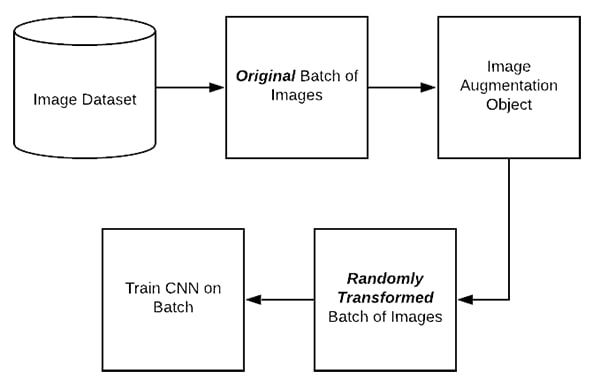

As an example we show the process of generating new images by means of translation, scaling, and vertical and horizontal flips. These processes are very basic manipulation of images but lots of CNN can't really tell that the processed image came from the original one in our dataset.

The following illustrations (curtesy of nanonets.com) show the effects of the said image manipulation:


*   Flip

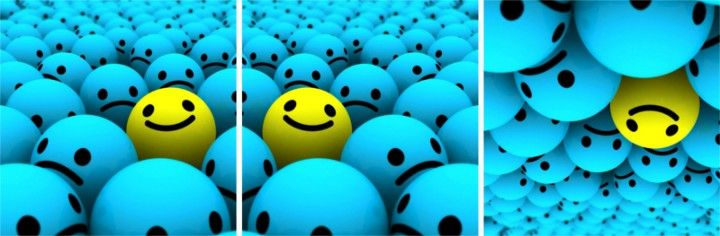




*   Rotation


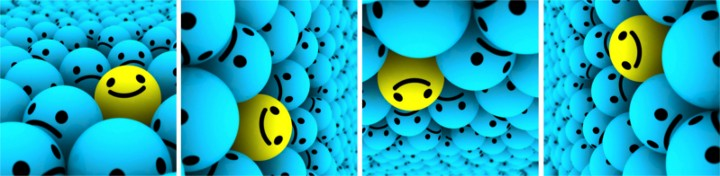




*   Scale


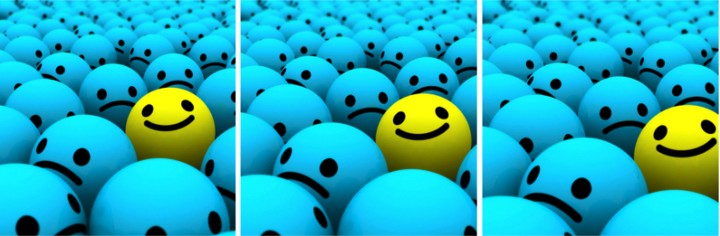

*   When the applied transformation leaves some blank areas the `fill_mode` define the way it is filled. The following image show the effects of `constant`, `edge`, `reflect`, `symmetric` and `wrap` modes

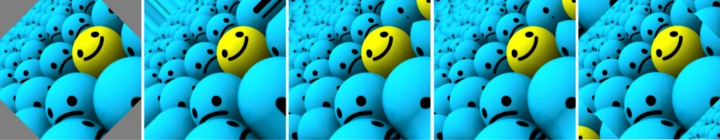



To carry out data augmentation we will use the 
```ImageDataGenerator``` class of Keras [doc](https://keras.io/api/preprocessing/image/)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

We define the desidered image manipulations using the `flow_from_directory` method. The methods returns a DirectoryIterator yielding tuples of (x, y) where x is a numpy array containing a batch of images with shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels.



There are many augmentation options and related parameters you can play with.

In [ ]:
train_dataset_path = 'Train'
img_width, img_height = (60, 60)

train_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rescale=1./255,
        #shear_range=0.2,
        #zoom_range=0.18,
        horizontal_flip=True,
        #vertical_flip=True,
        fill_mode='reflect', #  nearest?
        validation_split=0.1)
        
train_gen = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=(img_width, img_height),
    color_mode='grayscale', 
    class_mode='binary',
    subset='training')

val_gen = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    class_mode='binary',
    subset='validation')


Let's print the shape of the DirectoryIterator and get, each time, a new batch [[doc](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/DirectoryIterator)] 



In [ ]:
train_gen.next()[0].shape

In [ ]:
plt.imshow(train_gen.next()[0][1].squeeze(), cmap='gray')

In [ ]:
from keras.callbacks import ModelCheckpoint
#To make this exercise simpler, you will not use checkpoint in model.fit but we want to underline that often it is mandatory.
checkpoint = ModelCheckpoint(
    "model_augmented-{epoch:02d}-{val_accuracy:.2f}.h5", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode='auto', save_freq='epoch')

In [ ]:
#FILL HERE# You have to compile teh model 
model = make_model()
model.compile(...)

In [ ]:
#FILL HERE# 
epochs= ... # You can start from 50-100, then try to augment
batch_size = ...
history = model.fit(...
                    batch_size = ...
                    epochs = ...
                    validation_data = ...,
                    callbacks = [reduce_on_plateau]
                    )  


In [ ]:
#FILL HERE# Plot accuracy and loss curves on the train and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc)+1)
#Train and validation accuracy 
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(..
plt.plot(..
#Train and validation loss
plt.subplot(2, 2, 2)
plt.plot(..
plt.plot(..

# Saving the model

In [ ]:
!ls 

In [ ]:
model.save('model_augmented.h5') # it just saves the model at the last epoch  

In [ ]:
from keras.models import load_model

Load the model with the best validation accuracy. To select the best model have a look at the names of the saved models (the last number is the accuracy on validation) 

In [ ]:
imported_model = load_model('model_augmented.h5')

In [ ]:
imported_model.summary()

# Evaluate the performances of the two models

Load the models with and without augmentation which realized the best accuracy on validation

In [ ]:
model = load_model('model.h5')
model_aug = load_model('model_augmented.h5')
#to select the best models have a look at the names of the saved models
#(the last number is the accuracy on validation)  

In [ ]:
x_test, y_test = read_imgs('Test', [0,1])

In [ ]:
test_loss_noaug, test_acc_noaug = model.evaluate(x_test, y_test)
preds_test = model.predict(x_test, verbose=1)
fpr, tpr, _ = roc_curve(y_test, preds_test)
roc_auc = auc(fpr, tpr)

print('\n Test accuracy model no aug = %.3f'% (test_acc_noaug))
print('\n AUC = %.3f'% (roc_auc))

In [ ]:
test_loss_aug, test_acc_aug = model_aug.evaluate(x_test, y_test) # both model should be evaluated on the Test set
preds_test_aug = model_aug.predict(x_test, verbose=1)
fpr_aug, tpr_aug, _ = roc_curve(y_test, preds_test_aug)
roc_auc_aug = auc(fpr_aug, tpr_aug)

print('\n Test accuracy aug model = %.3f'% (test_acc_aug))
print('\n AUC = %.3f'% (roc_auc_aug))

Did you obtain an improvement of the performance on the *Test* set by using a data augmentation strategy?